**Phu Nguyen, Sean Nightingale**

Imports

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, accuracy_score, precision_recall_curve, precision_score, recall_score, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
import shap
from sklearn import svm

**Just some cells to help understand our data**

In [36]:
df = pd.read_csv("Dataset/diabetes_prediction_dataset.csv")
print(df.head())
print(df.info())
print(df.describe())
print(df.shape)


   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

In [37]:
# Replace 'No Info' with 'never' for age ≤ 5
df.loc[(df['age'] <= 5) & (df['smoking_history'] == 'No Info'), 'smoking_history'] = 'never'

# Display for confirmation
print(df[df['age'] <= 5])  # to check the changes

       gender   age  hypertension  heart_disease smoking_history    bmi  \
21       Male  5.00             0              0           never  18.80   
24     Female  4.00             0              0           never  13.99   
35       Male  5.00             0              0           never  15.10   
41       Male  5.00             0              0           never  27.32   
49     Female  3.00             0              0           never  19.27   
...       ...   ...           ...            ...             ...    ...   
99911  Female  0.32             0              0           never  18.37   
99916  Female  1.48             0              0           never  27.32   
99933  Female  5.00             0              0           never  13.34   
99940    Male  2.00             0              0           never  16.86   
99996  Female  2.00             0              0           never  17.37   

       HbA1c_level  blood_glucose_level  diabetes  
21             6.2                   85        

**Preprocess Stuff**

In [38]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

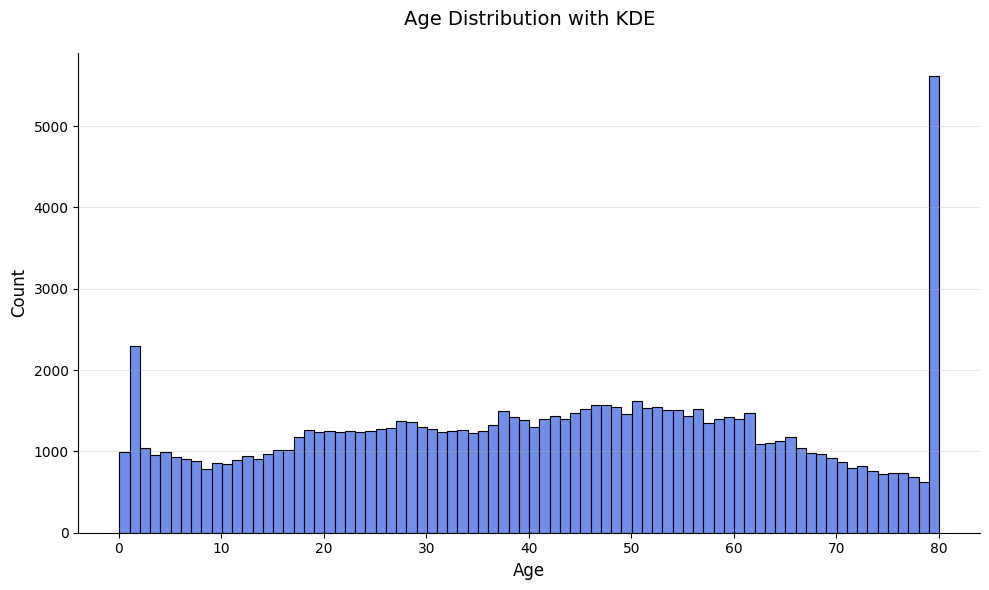

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='age', 
             bins=80,
             color='royalblue',
             edgecolor='black',
             linewidth=0.8)

plt.title('Age Distribution with KDE', 
          fontsize=14, 
          pad=20)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

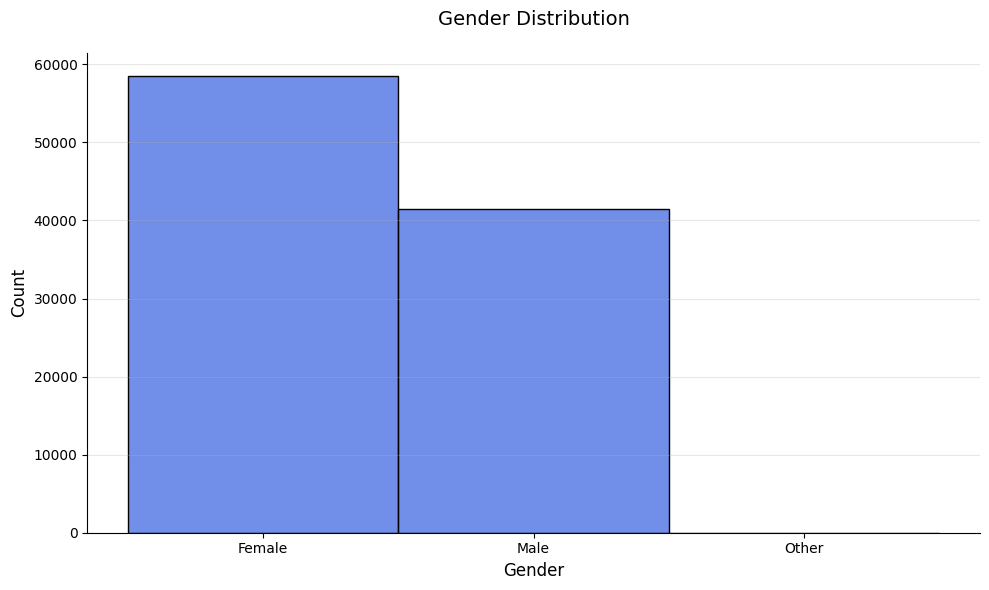

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='gender', 
             bins=3,
             color='royalblue',
             edgecolor='black',
             )

plt.title('Gender Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

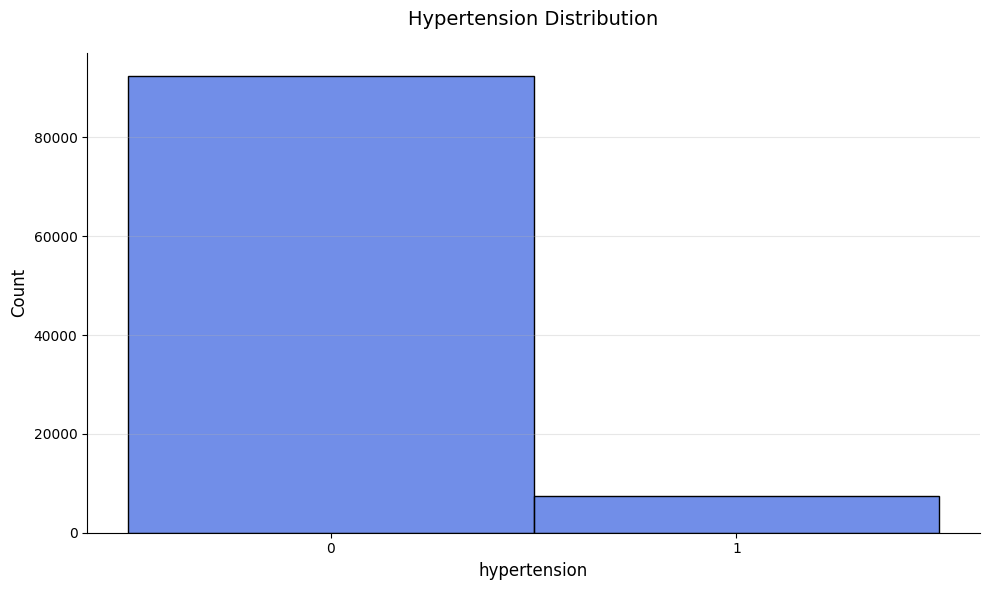

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='hypertension', 
             bins=[-0.5, 0.5, 1.5],
             color='royalblue',
             edgecolor='black',
             )

plt.title('Hypertension Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('hypertension', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1])
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

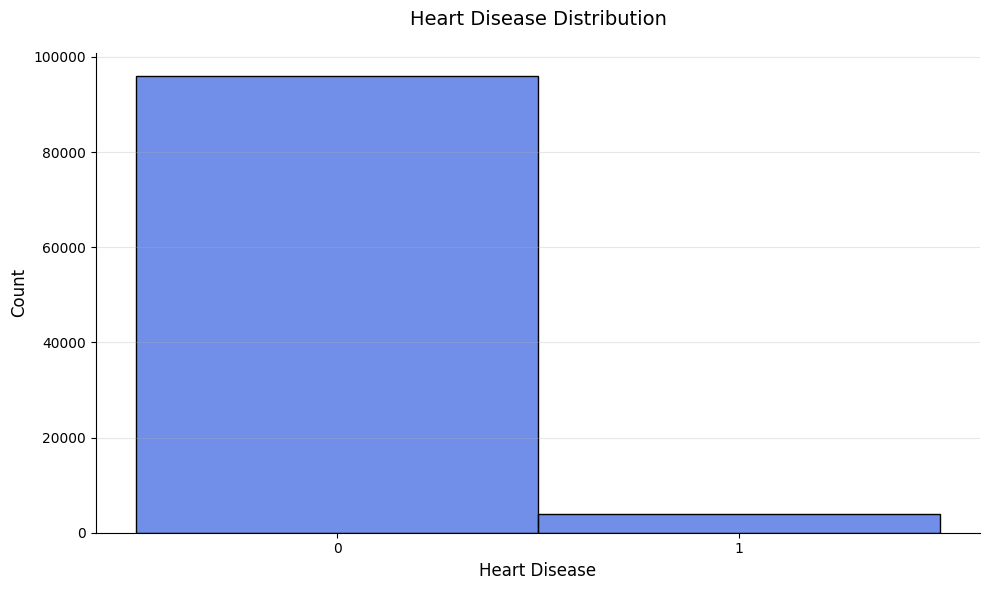

In [42]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, 
             x='heart_disease', 
             bins=[-0.5, 0.5, 1.5],  # Explicit bin edges centered at 0 and 1
             color='royalblue',
             edgecolor='black',
             )

plt.title('Heart Disease Distribution', fontsize=14, pad=20)
plt.xlabel('Heart Disease', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1]) 
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

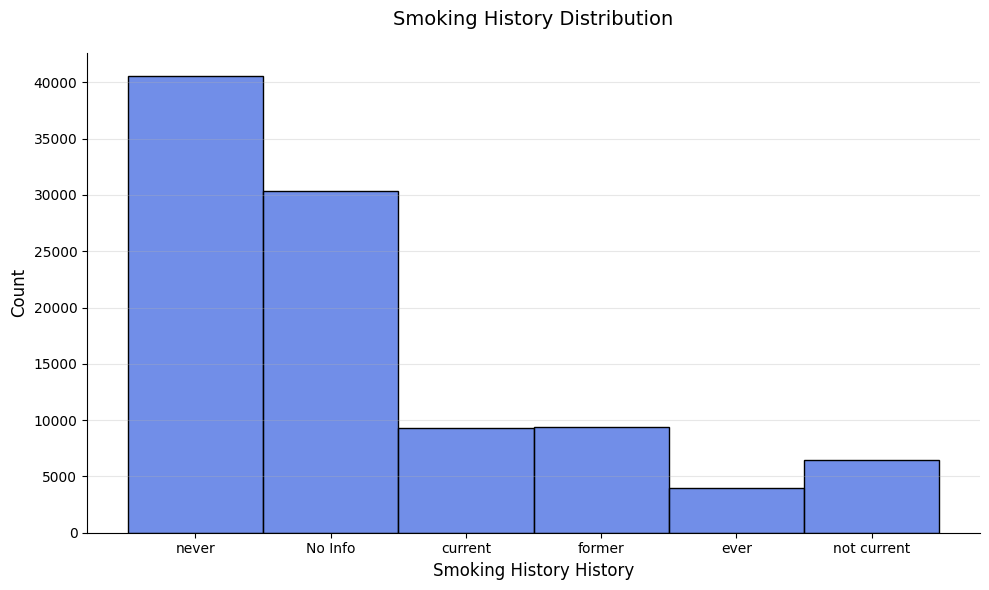

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, 
             x='smoking_history', 
             bins=3,
             color='royalblue',
             edgecolor='black',
             )

plt.title('Smoking History Distribution', 
          fontsize=14, 
          pad=20)
plt.xlabel('Smoking History History', fontsize=12)
plt.ylabel('Count', fontsize=12)
sns.despine()  # Remove top/right spines
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

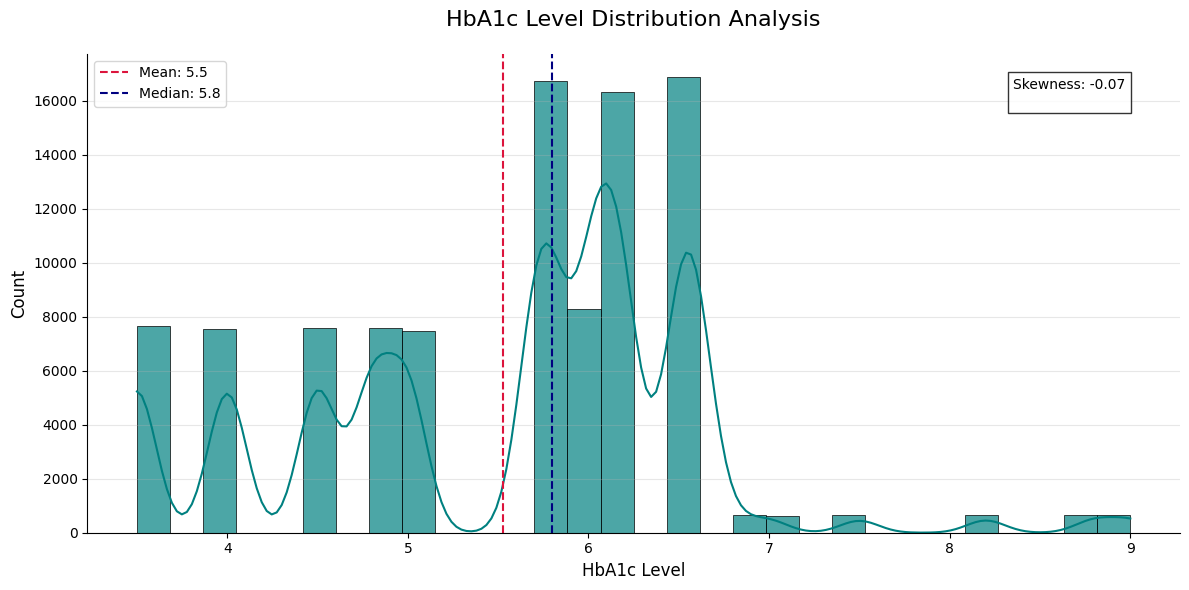

In [44]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='HbA1c_level',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_HbA1c_level = df['HbA1c_level'].mean()
median_HbA1c_level = df['HbA1c_level'].median()
plt.axvline(mean_HbA1c_level, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_HbA1c_level:.1f}')
plt.axvline(median_HbA1c_level, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_HbA1c_level:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["HbA1c_level"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('HbA1c Level Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('HbA1c Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

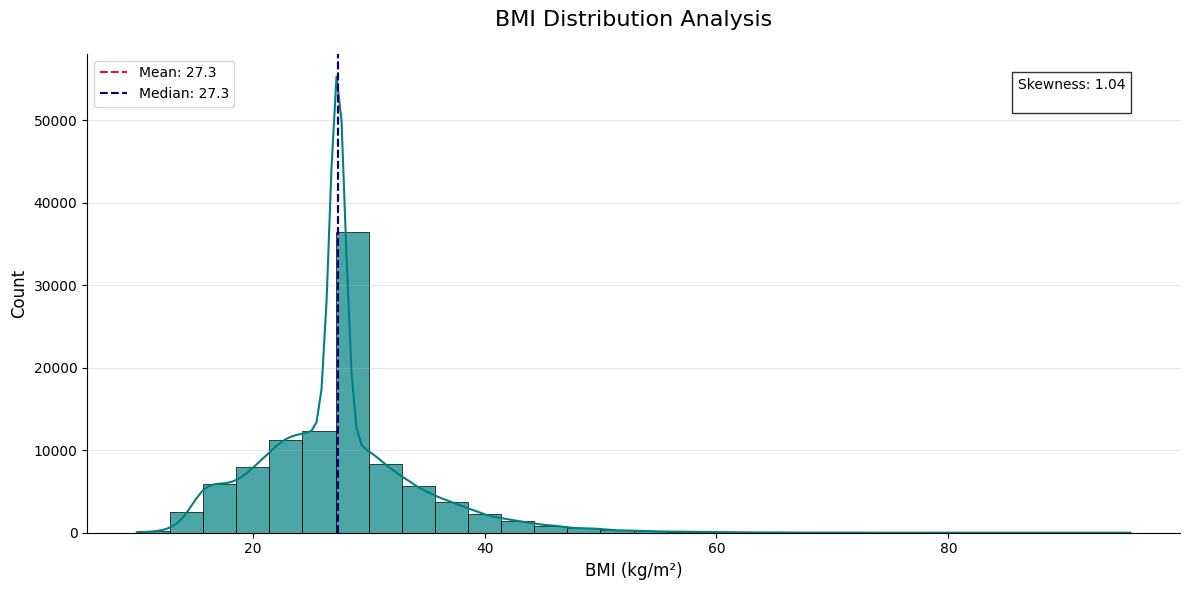

In [45]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='bmi',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_bmi = df['bmi'].mean()
median_bmi = df['bmi'].median()
plt.axvline(mean_bmi, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_bmi:.1f}')
plt.axvline(median_bmi, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_bmi:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["bmi"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('BMI Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('BMI (kg/m²)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

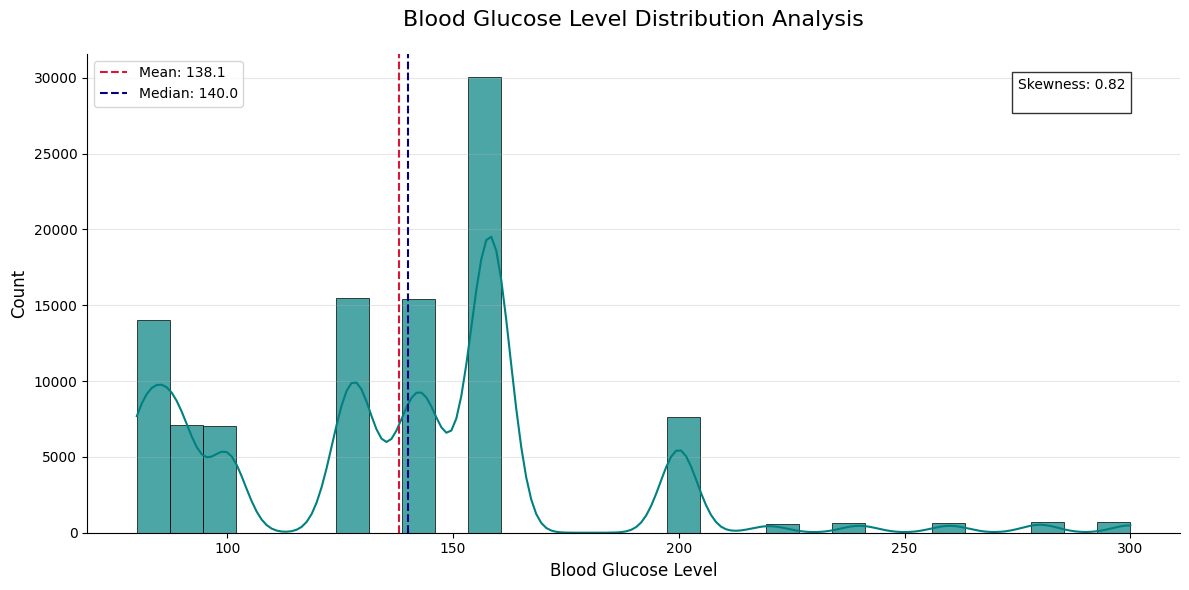

In [46]:
plt.figure(figsize=(12, 6))

# Create histogram with KDE
ax = sns.histplot(data=df,
                 x='blood_glucose_level',
                 bins=30,  # Adjust number of bins for granularity
                 kde=True,
                 color='teal',
                 edgecolor='black',
                 alpha=0.7,
                 linewidth=0.5)

# Add vertical lines for mean and median
mean_blood_glucose_level = df['blood_glucose_level'].mean()
median_blood_glucose_level = df['blood_glucose_level'].median()
plt.axvline(mean_blood_glucose_level, color='crimson', linestyle='--', linewidth=1.5, label=f'Mean: {mean_blood_glucose_level:.1f}')
plt.axvline(median_blood_glucose_level, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {median_blood_glucose_level:.1f}')

# Add annotations
plt.text(0.95, 0.95, 
        f'Skewness: {df["blood_glucose_level"].skew():.2f}\n',
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.title('Blood Glucose Level Distribution Analysis', fontsize=16, pad=20)
plt.xlabel('Blood Glucose Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
sns.despine()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

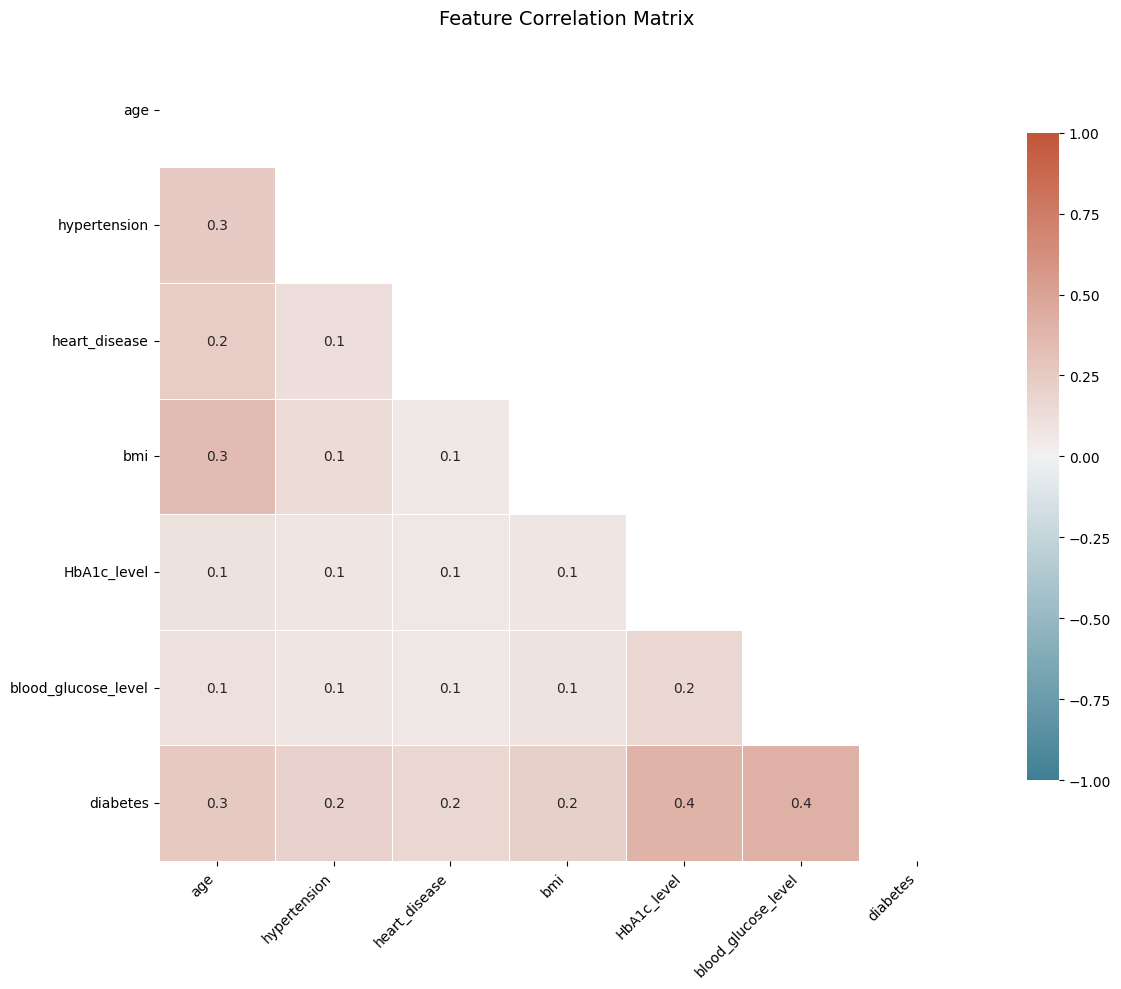

In [47]:
plt.figure(figsize=(12, 10))

# Calculate correlations
numeric_df = df.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_df.corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Generate heatmap
ax = sns.heatmap(corr_matrix,
                 mask=mask,
                 cmap=cmap,
                 vmin=-1, vmax=1,
                 center=0,
                 annot=True,
                 fmt=".1f",
                 linewidths=0.5,
                 annot_kws={"size": 10},
                 cbar_kws={"shrink": 0.8})

# Improve readability
plt.title("Feature Correlation Matrix", fontsize=14, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Remove empty space
plt.tight_layout()
plt.show()

**Data Preprocessing**

In [48]:
# le = LabelEncoder()
# categorical_cols = df.select_dtypes(include=['object', 'string']).columns
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col])

categorical_columns = df.select_dtypes(include=['object', 'string']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([df, one_hot_df], axis=1)

df_encoded = df_encoded.drop(categorical_columns, axis=1)
print(f"Encoded Employee data : \n{df_encoded}")


# Dropping gender, heart disease, hypertension, bmi, and smoking history because their impact on our data is negligible and not important
X = df_encoded.drop(['diabetes'], axis=1)  # Replace with your target column name
# X = df.drop(['diabetes', 'gender', 'heart_disease', 'smoking_history', 'bmi', 'hypertension'], axis=1)  # Replace with your target column name

y = df['diabetes']

class_ratios = y.value_counts(normalize=True)
print("\nClass ratios:")
print(class_ratios)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.head())


Encoded Employee data : 
        age  hypertension  heart_disease    bmi  HbA1c_level  \
0      80.0             0              1  25.19          6.6   
1      54.0             0              0  27.32          6.6   
2      28.0             0              0  27.32          5.7   
3      36.0             0              0  23.45          5.0   
4      76.0             1              1  20.14          4.8   
...     ...           ...            ...    ...          ...   
99995  80.0             0              0  27.32          6.2   
99996   2.0             0              0  17.37          6.5   
99997  66.0             0              0  27.83          5.7   
99998  24.0             0              0  35.42          4.0   
99999  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  gender_Female  gender_Male  \
0                      140         0            1.0          0.0   
1                       80         0            1.0          0.0   
2 

In [49]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verify new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
diabetes
0    73208
1    73208
Name: count, dtype: int64


**DECISION TREE CLASSIFIER**

In [92]:
clf = DecisionTreeClassifier(
    criterion='gini',  
    random_state=42
)
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(X_test)

class_names = ["No Diabetes", "Diabetes"]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.95
              precision    recall  f1-score   support

 No Diabetes       0.98      0.97      0.97     18292
    Diabetes       0.70      0.74      0.72      1708

    accuracy                           0.95     20000
   macro avg       0.84      0.86      0.85     20000
weighted avg       0.95      0.95      0.95     20000



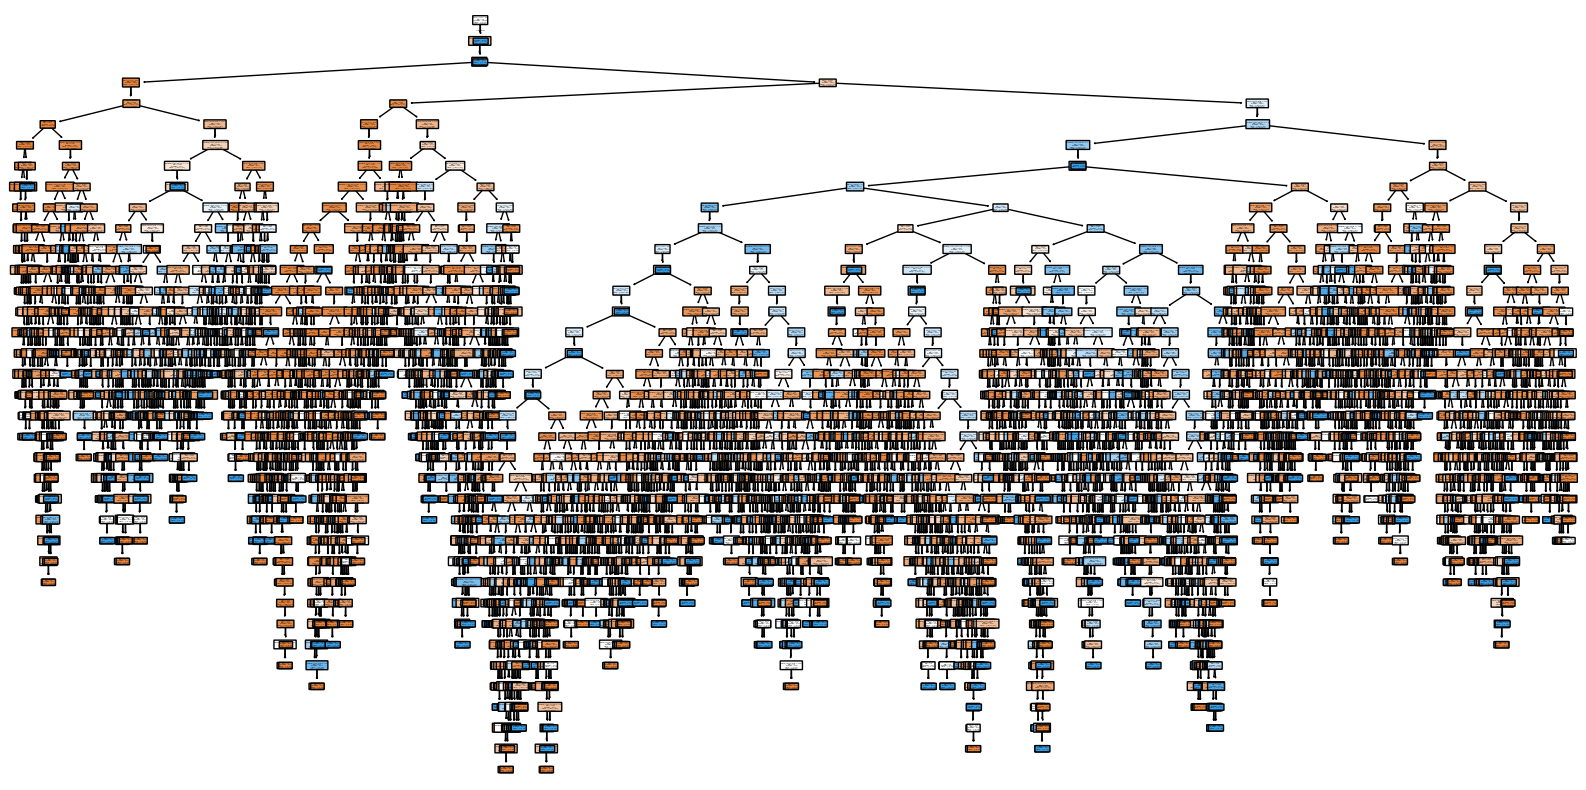

In [89]:
plt.figure(figsize=(20,10))
plot_tree(clf,
          feature_names=X.columns,
          class_names= ['Diabetes', 'No Diabetes'] ,
          filled=True,
          rounded=True,
          proportion=True)
plt.show()

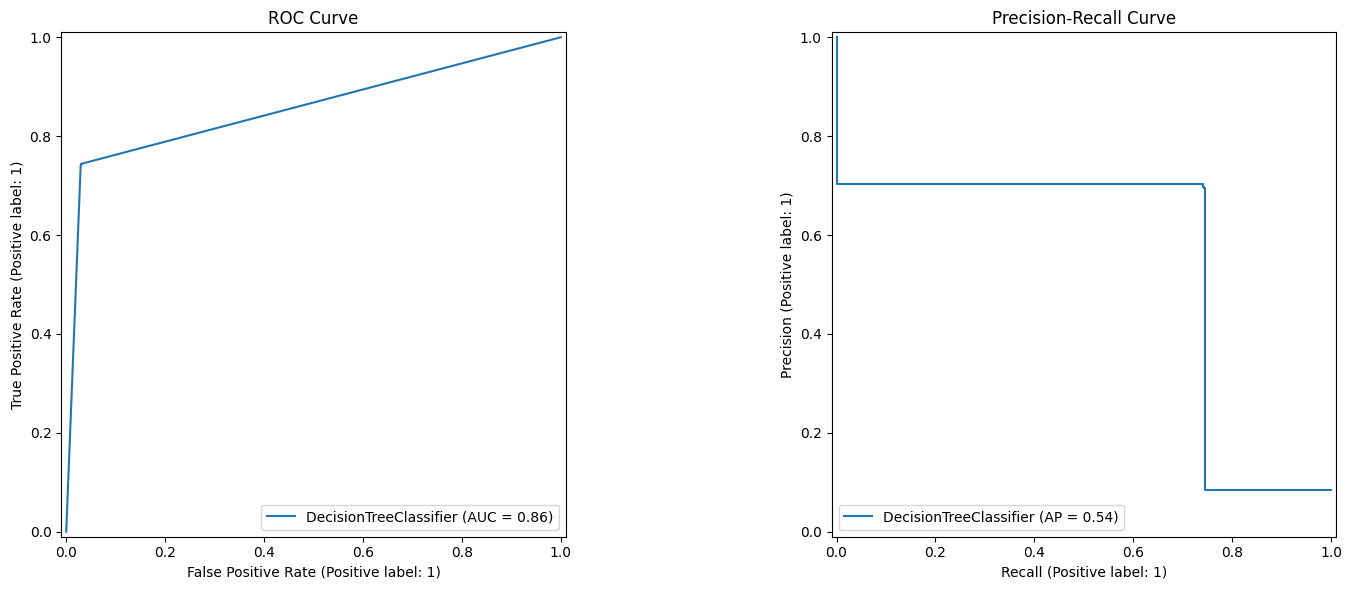

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax1)
ax1.set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

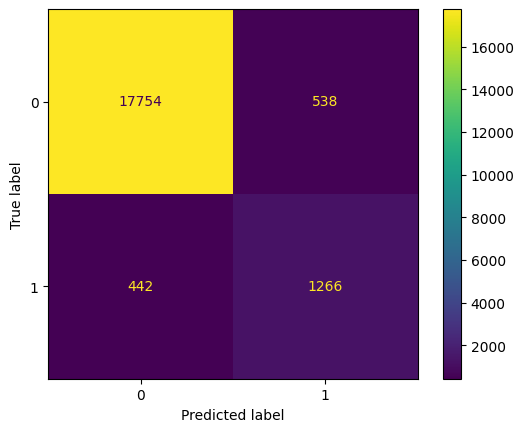

In [91]:
plt.figure(figsize=(20,10))

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

In [79]:
path = clf.cost_complexity_pruning_path(X_resampled, y_resampled)
ccp_alphas = path.ccp_alphas

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': [{0:1, 1:5}, {0:1, 1:6}, 'balanced'],
}

scoring = {
    'f1': 'f1',
    'recall': 'recall',
    'roc_auc': 'roc_auc',
}

grid_search = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          cv=5,
                          n_jobs=-1,
                          scoring=scoring,
                          refit='recall')
grid_search.fit(X_resampled, y_resampled)

best_clf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'class_weight': {0: 1, 1: 6}, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}


In [ ]:
clf = DecisionTreeClassifier(
    max_depth=3,  # Control tree depth to prevent overfitting
    min_samples_split=2,
    criterion='entropy',  # or 'entropy'
    class_weight={0: 1, 1: 6}, # Adding class weight to prioritize minority class
    random_state=42
)
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(X_test)

class_names = ["No Diabetes", "Diabetes"]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 No Diabetes       1.00      0.59      0.74     18292
    Diabetes       0.19      1.00      0.31      1708

    accuracy                           0.62     20000
   macro avg       0.59      0.79      0.53     20000
weighted avg       0.93      0.62      0.71     20000



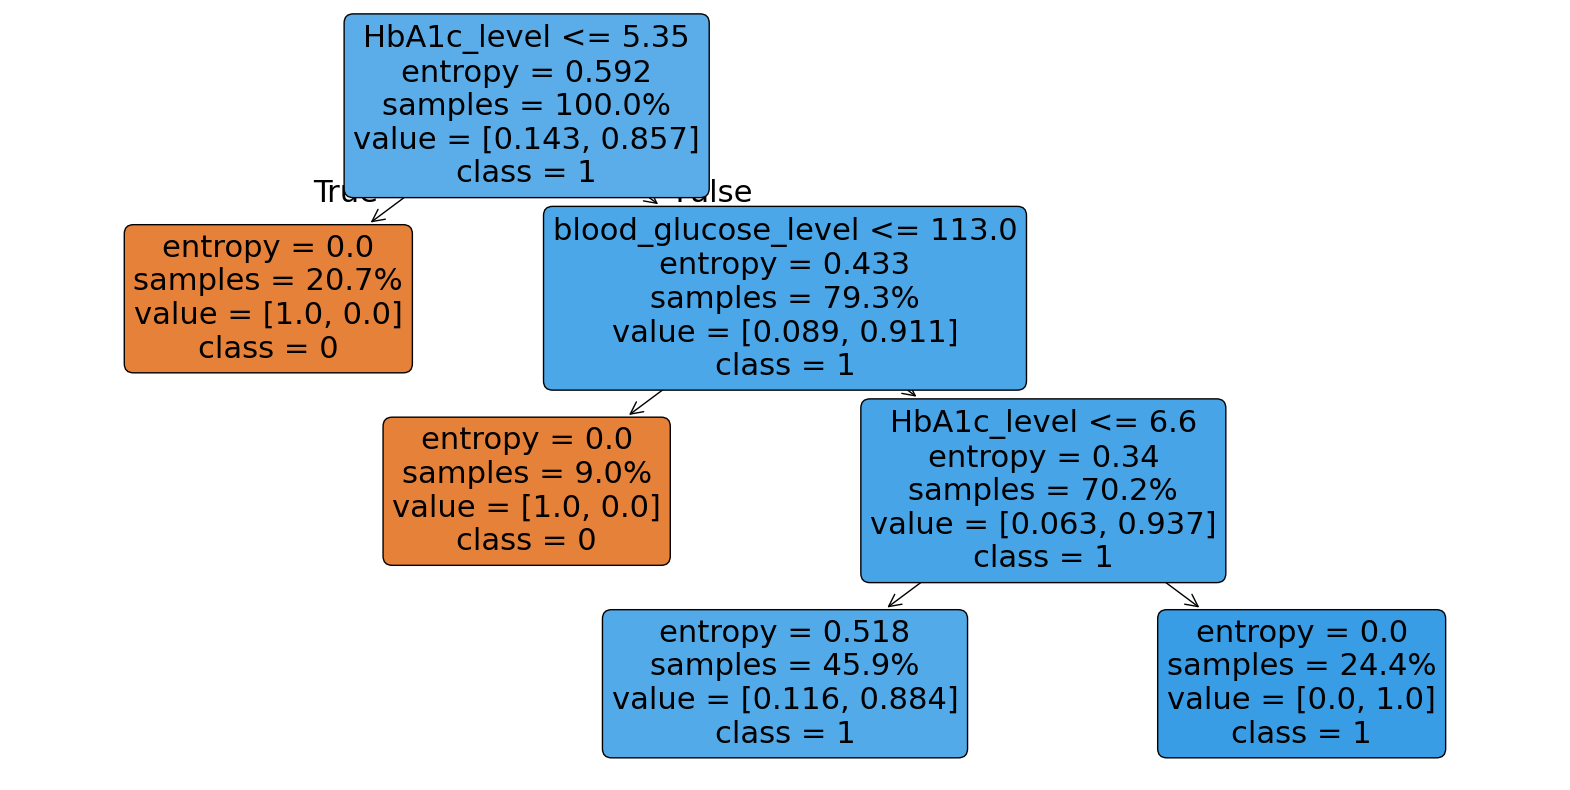

In [101]:
plt.figure(figsize=(20,10))
plot_tree(clf,
          feature_names=X.columns,
          class_names=[str(c) for c in df['diabetes'].unique()],
          filled=True,
          rounded=True,
          proportion=True)
plt.show()


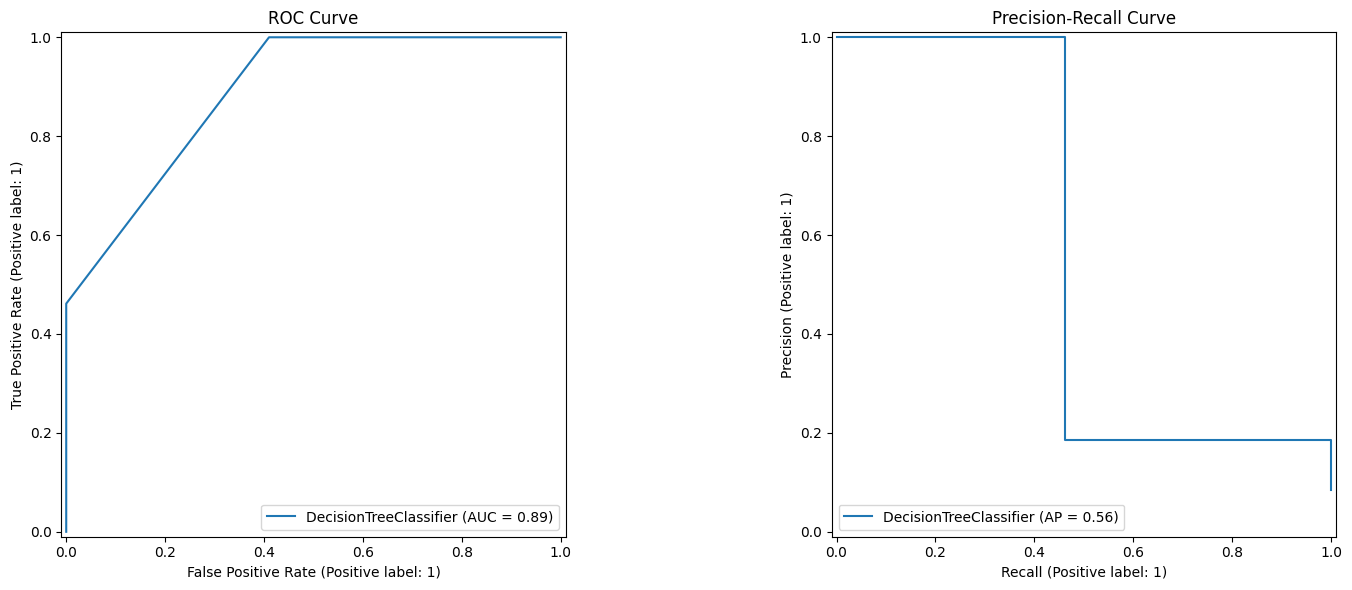

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax1)
ax1.set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

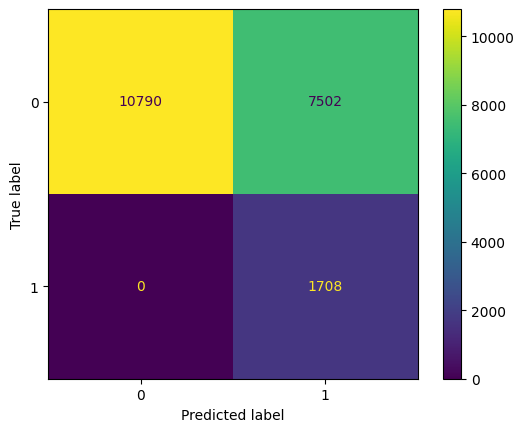

In [103]:
plt.figure(figsize=(20,10))

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

Feature Importances
                        Feature  Importance
4                   HbA1c_level    0.712252
5           blood_glucose_level    0.287748
0                           age    0.000000
2                 heart_disease    0.000000
1                  hypertension    0.000000
3                           bmi    0.000000
6                 gender_Female    0.000000
7                   gender_Male    0.000000
8                  gender_Other    0.000000
9       smoking_history_No Info    0.000000
10      smoking_history_current    0.000000
11         smoking_history_ever    0.000000
12       smoking_history_former    0.000000
13        smoking_history_never    0.000000
14  smoking_history_not current    0.000000


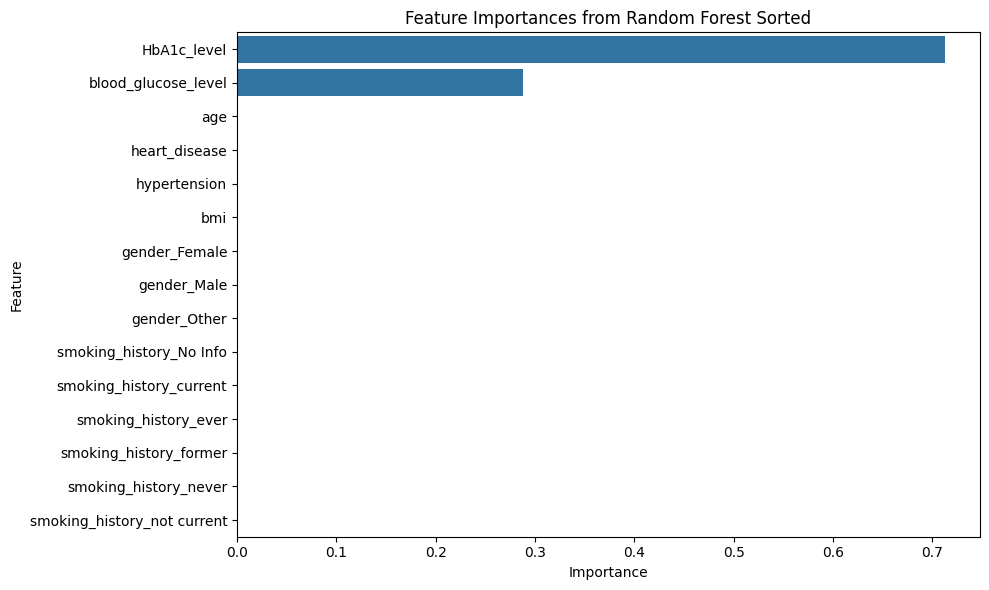

In [104]:
# Feature importance analysis

# Use feature names from the original DataFrame X
feature_names = X.columns

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for better readability and plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top features
print("Feature Importances")
print(feature_importance_df.head(len(feature_names)))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Feature Importances from Random Forest Sorted')
plt.tight_layout()
plt.show()

**ENSEMBLE CLASSIFIER**

In [93]:
# Base models
base_models = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])))
]

# Ensemble pipeline
ensemble_pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Optional: remove if not needed
    ('stack', StackingClassifier(
        estimators=base_models,
        final_estimator=XGBClassifier(),
        stack_method='predict_proba',
        passthrough=True
    ))
])

ensemble_pipe.fit(X_train, y_train)

y_pred = clf.predict(X_test)

class_names = ["No Diabetes", "Diabetes"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 No Diabetes       0.98      0.97      0.97     18292
    Diabetes       0.70      0.74      0.72      1708

    accuracy                           0.95     20000
   macro avg       0.84      0.86      0.85     20000
weighted avg       0.95      0.95      0.95     20000



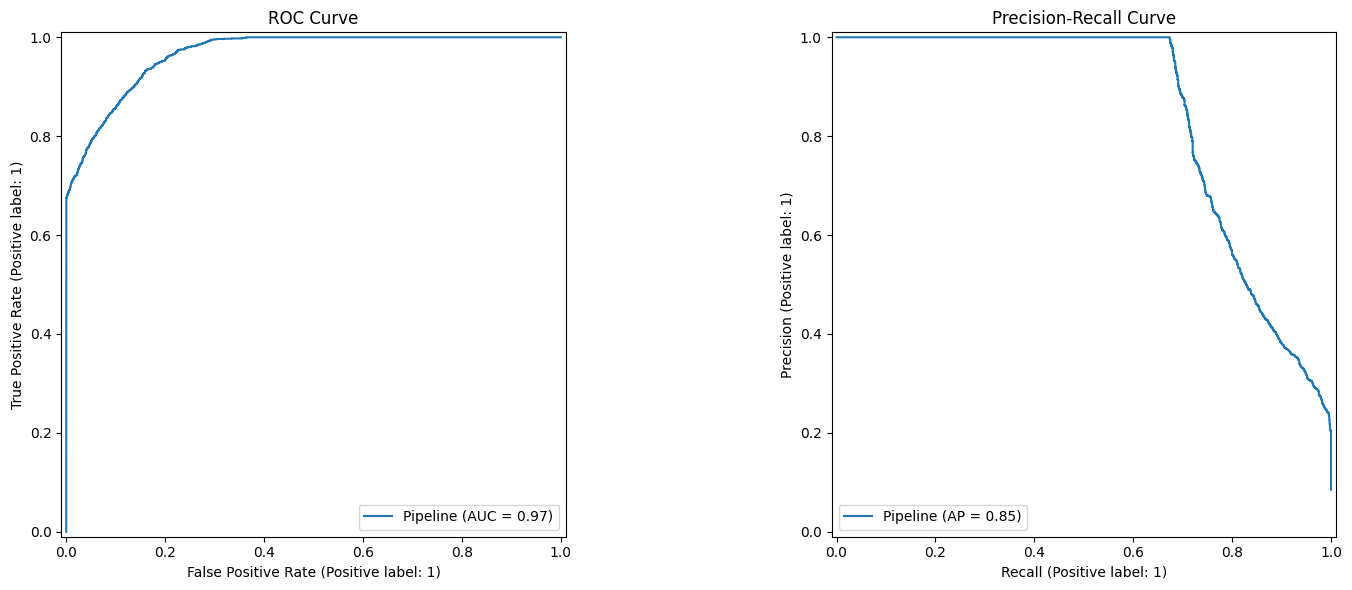

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(ensemble_pipe, X_test, y_test, ax=ax1)
ax1.set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(ensemble_pipe, X_test, y_test, ax=ax2)
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

Feature Importances
                        Feature  Importance
4                   HbA1c_level    0.473064
5           blood_glucose_level    0.267934
0                           age    0.110486
3                           bmi    0.040126
9       smoking_history_No Info    0.034758
7                   gender_Male    0.015501
6                 gender_Female    0.013972
12       smoking_history_former    0.012682
13        smoking_history_never    0.010960
14  smoking_history_not current    0.008692
10      smoking_history_current    0.005747
1                  hypertension    0.002497
2                 heart_disease    0.001810
11         smoking_history_ever    0.001765
8                  gender_Other    0.000005


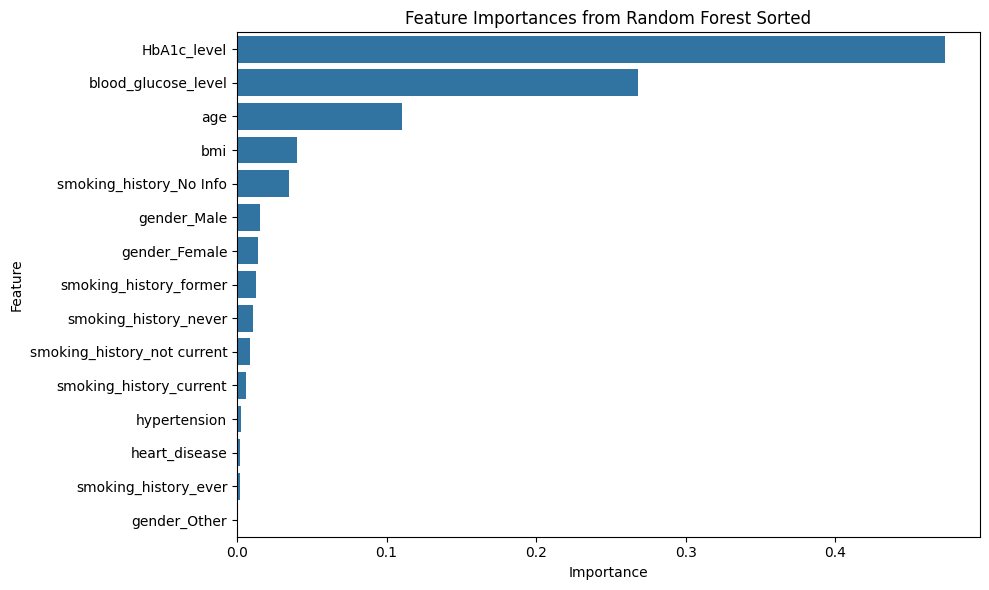

In [95]:
# Feature importance analysis

# Use feature names from the original DataFrame X
feature_names = X.columns

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for better readability and plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top features
print("Feature Importances")
print(feature_importance_df.head(len(feature_names)))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Feature Importances from Random Forest Sorted')
plt.tight_layout()
plt.show()

In [96]:
param_grid = {
    'smote__k_neighbors': [3, 5],  # SMOTE parameters
    'stack__rf__max_depth': [5, 7],
    'stack__xgb__learning_rate': [0.05, 0.1],
    'stack__final_estimator__max_depth': [3, 5]
}

scoring = {
    'f1': 'f1',
    'recall': 'recall',
    'roc_auc': 'roc_auc',
}

grid = GridSearchCV(
    ensemble_pipe,
    param_grid,
    scoring=scoring,
    refit='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('stack',
                                        StackingClassifier(estimators=[('rf',
                                                                        RandomForestClassifier(class_weight='balanced',
                                                                                               random_state=42)),
                                                                       ('xgb',
                                                                        XGBClassifier(base_score=None,
                                                                                      booster=None,
                                                                                      callbacks=None,
                                                                                      colsample_bylevel=None,
                                                                                      colsample_bynode=None,
                                                                                      colsample_bytree=None,
                                                                                      device=None,
                                                                                      early_stopping_rou...
                                                                                         n_estimators=None,
                                                                                         n_jobs=None,
                                                                                         num_parallel_tree=None, ...),
                                                           passthrough=True,
                                                           stack_method='predict_proba'))]),
             n_jobs=-1,
             param_grid={'smote__k_neighbors': [3, 5],
                         'stack__final_estimator__max_depth': [3, 5],
                         'stack__rf__max_depth': [5, 7],
                         'stack__xgb__learning_rate': [0.05, 0.1]},
             refit='recall',
             scoring={'f1': 'f1', 'recall': 'recall', 'roc_auc': 'roc_auc'},
             verbose=2)

In [97]:
best_model = grid.best_estimator_
print(f"Best Parameters: {grid.best_params_}")

Best Parameters: {'smote__k_neighbors': 3, 'stack__final_estimator__max_depth': 3, 'stack__rf__max_depth': 5, 'stack__xgb__learning_rate': 0.05}


In [98]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.97      0.69      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



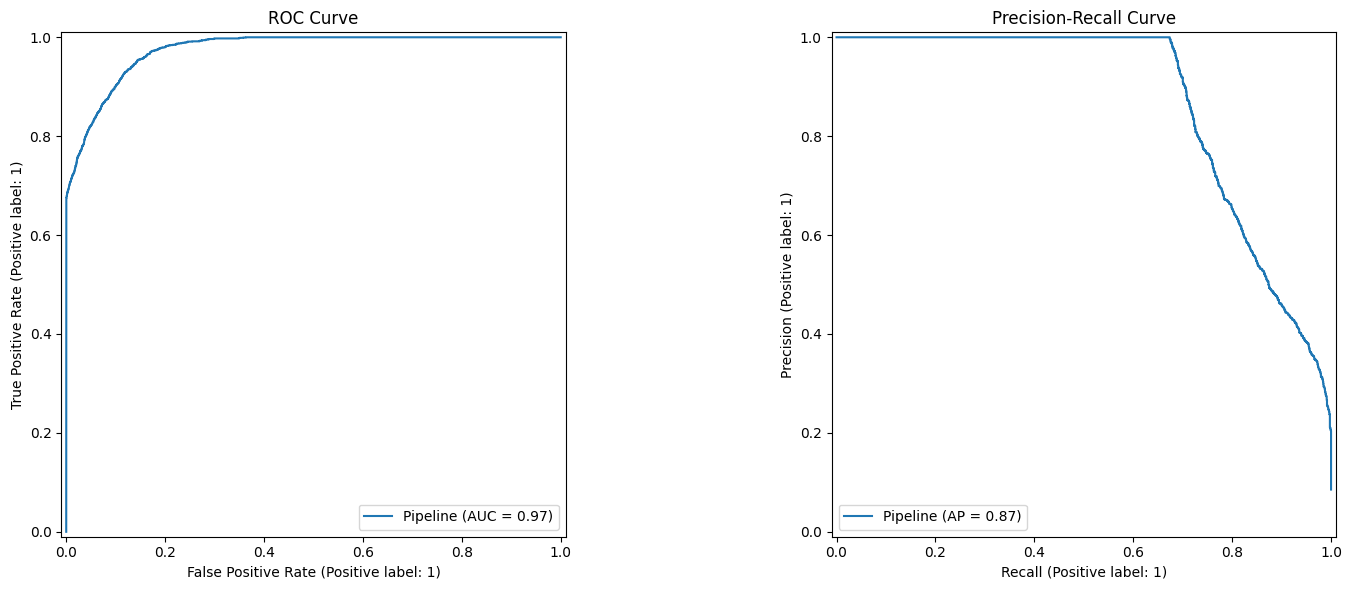

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax1)
ax1.set_title('ROC Curve')

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=ax2)
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

**SVM Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Define feature splits
dt_features = ['age', 'HbA1c_level', 'blood_glucose_level']
svm_features = [col for col in X.columns if col not in dt_features]

# Apply SMOTE to Decision Tree features
smote = SMOTE(random_state=42)
X_dt_train_resampled, y_dt_train_resampled = smote.fit_resample(X_train[dt_features], y_train)

# Train Decision Tree on resampled data
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_dt_train_resampled, y_dt_train_resampled)

# Apply SMOTE to SVM features
X_svm_train_resampled, y_svm_train_resampled = smote.fit_resample(X_train[svm_features], y_train)

# Train SVM without probability
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_svm_train_resampled, y_svm_train_resampled)

# Predict class labels
dt_preds = dt.predict(X_test[dt_features])
svm_preds = svm.predict(X_test[svm_features])

# Combine predictions with majority voting
final_preds = []
for d, s in zip(dt_preds, svm_preds):
    final_preds.append(1 if d + s >= 1 else 0)  # simple majority vote

# Evaluate
print("🔀 Hybrid Model (DT + SVM w/ SMOTE) — Majority Vote:")
print(classification_report(y_test, final_preds))

In [ ]:
import joblib

# Save models to disk
joblib.dump(dt, "decision_tree__smote_model.joblib")
joblib.dump(svm, "svm_rbf_smote_model.joblib")

print("✅ Models saved: decision_tree__smote_model.joblib and svm_rbf_smote_model.joblib")

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Define feature splits
dt_features = ['age', 'HbA1c_level', 'blood_glucose_level']
svm_features = [col for col in X.columns if col not in dt_features]

# Apply SMOTE to Decision Tree features
smote = SMOTE(random_state=42)
X_dt_train_resampled, y_dt_train_resampled = smote.fit_resample(X_train[dt_features], y_train)

# Train Decision Tree on resampled data
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_dt_train_resampled, y_dt_train_resampled)

# Apply SMOTE to SVM features
X_svm_train_resampled, y_svm_train_resampled = smote.fit_resample(X_train[svm_features], y_train)

# Train SVM without probability
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_svm_train_resampled, y_svm_train_resampled)

# Predict class labels
dt_preds = dt.predict(X_test[dt_features])
svm_preds = svm.predict(X_test[svm_features])

# Combine predictions with majority voting
final_preds = []
for d, s in zip(dt_preds, svm_preds):
    final_preds.append(1 if d + s >= 1 else 0)  # simple majority vote

# Evaluate
print("🔀 Hybrid Model (DT + SVM w/ SMOTE) — Majority Vote:")
print(classification_report(y_test, final_preds))

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Define features NOT used by the DT
svm_features = [col for col in X.columns if col not in ['HbA1c_level', 'blood_glucose_level']]

# Apply SMOTE to those features
smote = SMOTE(random_state=42)
X_resampled_svm, y_resampled_svm = smote.fit_resample(X_train[svm_features], y_train)

# Train the SVM (RBF) without probability (faster)
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_resampled_svm, y_resampled_svm)

# Predict and evaluate
y_pred_svm = svm.predict(X_test[svm_features])

print("💻 SVM (RBF) — SMOTE, All Features Except HbA1c & Glucose:")
print(classification_report(y_test, y_pred_svm, target_names=["No Diabetes", "Diabetes"]))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Use only the two selected features
dt_features = ['HbA1c_level', 'blood_glucose_level']

# Apply SMOTE to selected features
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train[dt_features], y_train)

# Define and train the decision tree with your parameters
clf = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=2,
    criterion='entropy',
    class_weight={0: 1, 1: 6},
    probability=True,
    random_state=42
)
clf.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = clf.predict(X_test[dt_features])

class_names = ["No Diabetes", "Diabetes"]
print("🌿 Decision Tree (HbA1c + Glucose w/ SMOTE):")
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
final_preds = []
for d, s in zip(y_pred, y_pred_svm):
    # Trust SVM more, only let DT flip a 0 if both say 1
    if s == 1 and d == 1:
        final_preds.append(1)
    else:
        final_preds.append(0)

print("💻 SVM (RBF) — SMOTE, All Features Except HbA1c & Glucose:")
print(classification_report(y_test, final_preds, target_names=["No Diabetes", "Diabetes"]))